# Setup

In [3]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import pandas as pd
import time
from scipy.stats import norm, lognorm, gamma, invgamma

In [4]:
# # Test Graph

# testGraph = ox.graph.graph_from_point((38.539078, -121.752065), dist=250, network_type='bike')
# fig, ax = ox.plot.plot_graph(testGraph)

# # Save the graph for offline access
# ox.io.save_graphml(testGraph, "testGraph.graphml")

In [5]:
# # Bounding box for the full Davis network
# bbox = (-121.794484891,38.5235690581,-121.6752063856,38.5755508478)

In [6]:
# # Bike Network Graph
# bikeGraph = ox.graph.graph_from_bbox(bbox, network_type='bike')
# fig, ax = ox.plot.plot_graph(bikeGraph)

# # Save the graph for offline access
# ox.io.save_graphml(bikeGraph, "bikeGraph.graphml")

In [7]:
# # Driving Network Graph
# driveGraph = ox.graph.graph_from_bbox(bbox, network_type='drive')
# fig, ax = ox.plot.plot_graph(driveGraph)

# # Save the graph for offline access
# ox.io.save_graphml(driveGraph, "driveGraph.graphml")

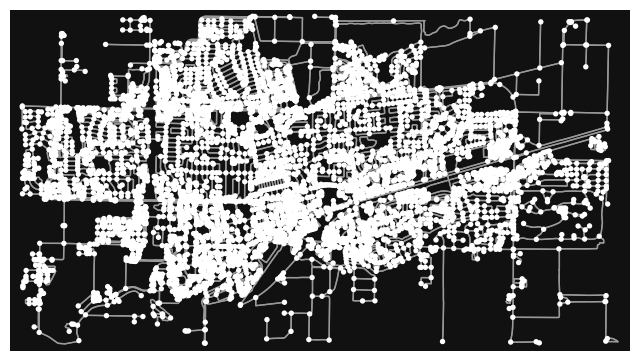

In [8]:
bikeGraph = ox.io.load_graphml("bikeGraph.graphml")
fig, ax = ox.plot.plot_graph(bikeGraph)

In [9]:
bikeNodes, bikeEdges = ox.graph_to_gdfs(bikeGraph)
bikeEdges.index.get_level_values("key").unique()

Index([0, 1, 2], dtype='int64', name='key')

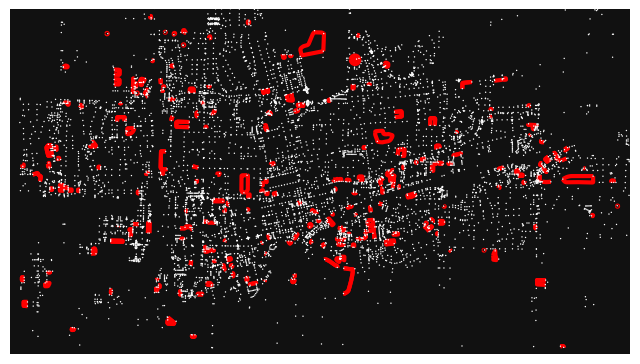

In [10]:
# Find edges with key 1 and 2
parallel_edge_keys = set()
for u, v, key in bikeGraph.edges(keys=True):
    if key in [1, 2]:
        parallel_edge_keys.add((u, v, key))

# Create subgraph with only those edges
subgraph = bikeGraph.copy()
edges_to_remove = [(u, v, k) for u, v, k in bikeGraph.edges(keys=True) 
                   if (u, v, k) not in parallel_edge_keys]
subgraph.remove_edges_from(edges_to_remove)

# Plot
fig, ax = ox.plot_graph(subgraph, node_size=1, edge_linewidth=3, 
                        edge_color='red', show=True, close=False)
ax.set_title('Bike Graph: Edges with Key = 1 or 2')
plt.show()

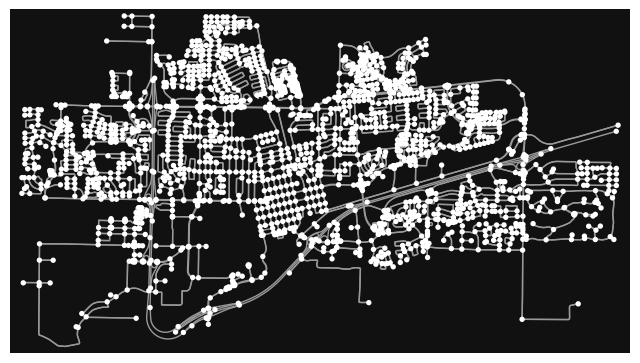

In [11]:
driveGraph = ox.io.load_graphml("driveGraph.graphml")
fig, ax = ox.plot.plot_graph(driveGraph)

In [12]:
driveNodes, driveEdges = ox.graph_to_gdfs(bikeGraph)
driveEdges.index.get_level_values("key").unique()

Index([0, 1, 2], dtype='int64', name='key')

In [13]:
testGraph = ox.io.load_graphml("testGraph.graphml")
testGraph = ox.routing.add_edge_speeds(testGraph)
testGraph = ox.routing.add_edge_travel_times(testGraph)
nodes, edges = ox.graph_to_gdfs(testGraph)

In [14]:
nodes

,y,x,street_count,geometry
osmid,,,,
95712770,38.539061,-121.750066,4,POINT (-121.75007 38.53906)
95716931,38.539897,-121.752174,3,POINT (-121.75217 38.5399)
95716932,38.540452,-121.750152,3,POINT (-121.75015 38.54045)
265024842,38.539079,-121.752408,3,POINT (-121.75241 38.53908)
271831022,38.540693,-121.753224,3,POINT (-121.75322 38.54069)
...,...,...,...,...
9156382464,38.540655,-121.754299,1,POINT (-121.7543 38.54066)
9159686623,38.540076,-121.750046,3,POINT (-121.75005 38.54008)
10684990777,38.538269,-121.754512,3,POINT (-121.75451 38.53827)


In [15]:
# The keys are "u" (start node), "v" (end node), and "key" (used for if there are multiple edges between node pairs).
# Because we don't have any multiple edges, we drop the "key" key to simplify our operations later.
# Theoretically, we could store higher probability and have the policy table store which edge was used, but that's not within my scope
edges

osmid   highway maxspeed  \
u           v           key                                              
95712770    277046658   0                  24411964  cycleway   15 mph   
            273245111   0                  24411964  cycleway   15 mph   
            273245096   0     [41889625, 991366978]  cycleway   15 mph   
            9159686623  0    [991366978, 391112883]  cycleway   15 mph   
95716931    559373141   0                  10746426  cycleway   15 mph   
...                                             ...       ...      ...   
10684990793 639324548   0                 218405222  cycleway      NaN   
            10684990777 0                1148407870  cycleway      NaN   
10684990794 10684990793 0                 218405222  cycleway      NaN   
            272014000   0                 218405222  cycleway      NaN   
            5674111324  0                1148407872   service   10 mph   

                                               name  oneway  reversed  \
u           v           key                                             
95712770    277046658   0           Hutchison Drive   False     False   
            273245111   0           Hutchison Drive   False      True   
            273245096   0                       NaN   False     False   
            9159686623  0                       NaN   False      True   
95716931    559373141   0    Peter J Shields Avenue   False     False   
...                                             ...     ...       ...   
10684990793 639324548   0                       NaN   False     False   
            10684990777 0                       NaN   False     False   
10684990794 10684990793 0                       NaN   False     False   
            272014000   0                       NaN   False      True   
            5674111324  0                       NaN   False     False   

                                 length  speed_kph  travel_time  \
u           v           key                                       
95712770    277046658   0     74.445826    24.1401    11.102066   
            273245111   0     55.648905    24.1401     8.298891   
            273245096   0    114.247851    24.1401    17.037720   
            9159686623  0    114.477385    24.1401    17.071950   
95716931    559373141   0     75.307218    24.1401    11.230525   
...                                 ...        ...          ...   
10684990793 639324548   0     23.446030    24.1401     3.496494   
            10684990777 0    101.269759    24.1401    15.102304   
10684990794 10684990793 0     17.320981    24.1401     2.583069   
            272014000   0     62.708203    24.1401     9.351640   
            5674111324  0    133.388708    16.0934    29.838278   

                                                                      geometry  \
u           v           key                                                      
95712770    277046658   0    LINESTRING (-121.75007 38.53906, -121.75092 38...   
            273245111   0    LINESTRING (-121.75007 38.53906, -121.74983 38...   
            273245096   0    LINESTRING (-121.75007 38.53906, -121.75006 38...   
            9159686623  0    LINESTRING (-121.75007 38.53906, -121.75007 38...   
95716931    559373141   0    LINESTRING (-121.75217 38.5399, -121.7521 38.5...   
...                                                                        ...   
10684990793 639324548   0    LINESTRING (-121.75362 38.53785, -121.75368 38...   
            10684990777 0    LINESTRING (-121.75362 38.53785, -121.75364 38...   
10684990794 10684990793 0    LINESTRING (-121.75343 38.53789, -121.75362 38...   
            272014000   0    LINESTRING (-121.75343 38.53789, -121.75333 38...   
            5674111324  0    LINESTRING (-121.75343 38.53789, -121.75345 38...   

                            junction lanes        service  
u           v           key                                
95712770    277046658   0        NaN   NaN            NaN  
            27

In [16]:
ox.stats.basic_stats(testGraph)

{'n': 105,
 'm': 221,
 'k_avg': 4.20952380952381,
 'edge_length_total': 9107.774741276287,
 'edge_length_avg': 41.21165041301487,
 'streets_per_node_avg': 2.8857142857142857,
 'streets_per_node_counts': {0: 0, 1: 7, 2: 2, 3: 92, 4: 4},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.06666666666666667,
  2: 0.01904761904761905,
  3: 0.8761904761904762,
  4: 0.0380952380952381},
 'intersection_count': 98,
 'street_length_total': 4995.196359569827,
 'street_segment_count': 142,
 'street_length_avg': 35.17743915190019,
 'circuity_avg': 1.092330055625545,
 'self_loop_proportion': 0.0}

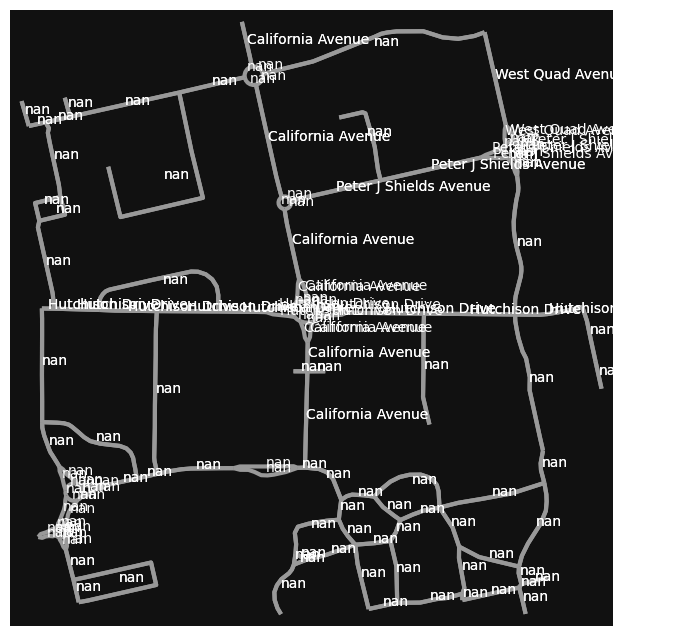

In [17]:
fig, ax = ox.plot_graph(testGraph, edge_linewidth=3, node_size=0, show=False, close=False)
for key, data  in edges.iterrows():
    text = data['name']
    c = data['geometry'].centroid
    ax.annotate(text, (c.x, c.y), c='w')
plt.show()

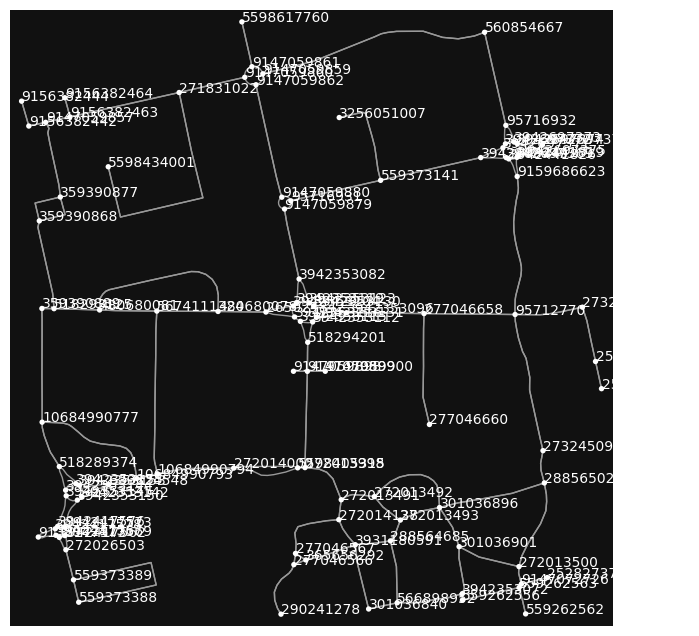

In [18]:
fig, ax = ox.plot.plot_graph(testGraph,show=False,close=False)
for key, data in nodes.iterrows():
    text = key
    labelLoc = data["geometry"].centroid
    ax.annotate(text, (labelLoc.x, labelLoc.y), c='w')
plt.show()

# Modify bike network

### Old Implementation

This is old code that modified the edges dataframe by assuming a single speed for all bicyclists. This is now deprecated due to the use of the empirical bike speed data.

In [19]:
def modifyEdgesBike(bikeSpeed, edgeGDF, unit='mph'):
    # Create a copy of the edge GeoDataFrame to avoid modifying the original
    modifiedEdges = edgeGDF.copy()
    
    # Validate unit input
    if unit not in ['mph', 'kph']:
        raise ValueError("Unit must be either 'mph' or 'kph'")
    
    # Convert bike speed to kph if necessary
    elif unit == 'mph':
        bikeSpeed = bikeSpeed * 1.60934  # convert mph to kph
    
    # Set new edge speeds
    modifiedEdges['speed_kph'] = bikeSpeed

    # Set new travel times in seconds
    modifiedEdges['travel_time'] = modifiedEdges['length'] / (modifiedEdges['speed_kph'] * 1000 / 3600)
    return modifiedEdges

In [20]:
testEdges = modifyEdgesBike(10, edges, unit='mph')

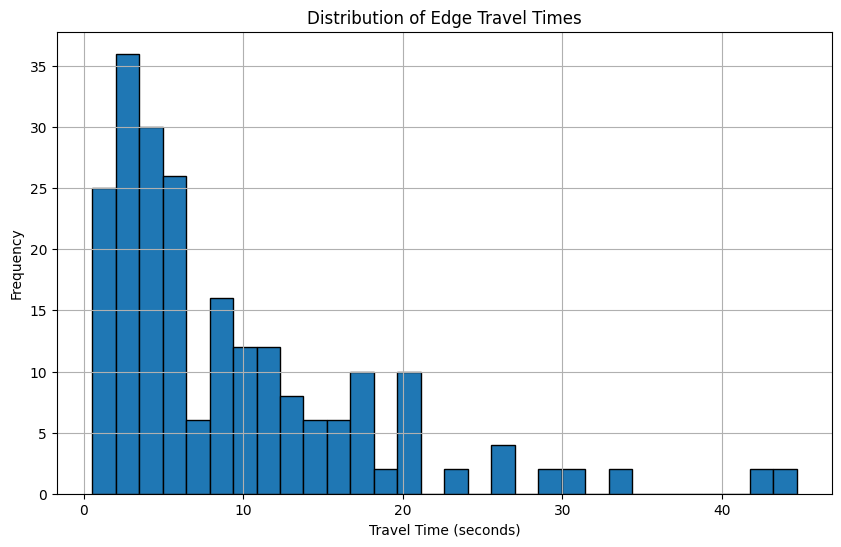

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
testEdges["travel_time"].hist(bins=30, ax=ax, edgecolor='black')
ax.set_xlabel('Travel Time (seconds)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Edge Travel Times')
plt.show()

### Using empirical bike speed data to create travel time distributions

In [22]:
# Read bike speed data
bikeSpeeds = pd.read_excel("Bike Speeds.xlsx")
bikeSpeeds = bikeSpeeds.set_index('Speed (mph)')
bikeSpeeds["Speed (m/s)"] = bikeSpeeds.index * 0.44704
bikeSpeeds

,2026-01-22 00:00:00,2026-01-23 00:00:00,2026-01-24 00:00:00,2026-01-25 00:00:00,2026-01-26 00:00:00,2026-01-27 00:00:00,2026-01-28 00:00:00,Total,Speed (m/s)
Speed (mph),,,,,,,,,
1,0,0,0,0,1,0,0,1,0.44704
2,1,1,0,0,3,2,0,7,0.89408
3,4,5,3,0,2,0,4,18,1.34112
4,3,4,2,0,2,8,7,26,1.78816
5,8,8,1,4,8,6,6,41,2.23520
6,24,23,6,10,20,18,22,123,2.68224
7,40,63,16,15,43,49,39,265,3.12928
8,120,122,43,42,110,118,128,683,3.57632
9,171,199,66,61,194,213,220,1124,4.02336


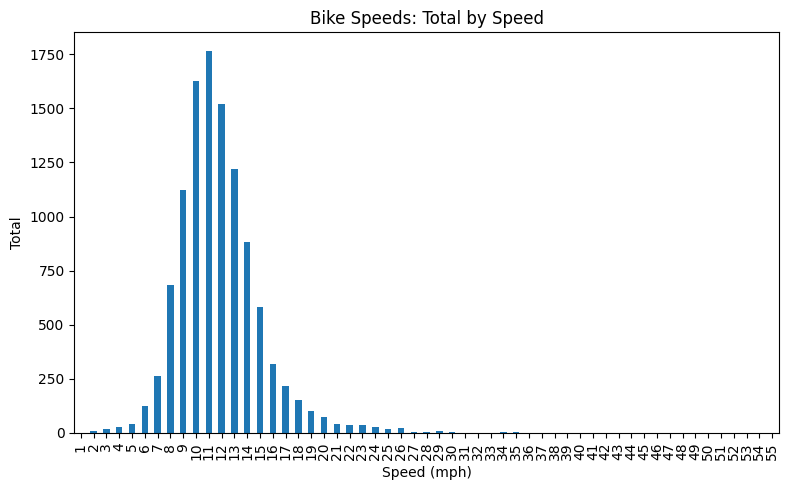

In [23]:
# Plot bike speed data
fig, ax = plt.subplots(figsize=(8, 5))
bikeSpeeds["Total"].plot(kind="bar", ax=ax)
ax.set_xlabel("Speed (mph)")
ax.set_ylabel("Total")
ax.set_title("Bike Speeds: Total by Speed")
plt.tight_layout()
plt.show()

The speed distribution seems to be approximately normal, but with a slight right skew. Because we want distributions for travel time rather than speed, we will hold off on fitting the distribution.

In [24]:
# # This code fits distributions to the bike speed data, which is not needed

# # Build a sample from the binned counts
# speeds = bikeSpeeds["Speed (m/s)"].to_numpy()
# counts = bikeSpeeds["Total"].to_numpy().astype(int)
# sample = np.repeat(speeds, counts)

# # Fit distributions
# norm_params = norm.fit(sample)
# lognorm_params = lognorm.fit(sample, floc=0)
# gamma_params = gamma.fit(sample, floc=0)

# # Plot histogram and fitted PDFs
# fig, ax = plt.subplots(figsize=(8, 5))
# ax.hist(sample, bins=55, density=True, alpha=0.4, edgecolor="black", label="Empirical")

# x = np.linspace(sample.min(), sample.max(), 300)
# ax.plot(x, norm.pdf(x, *norm_params), label="Normal fit")
# ax.plot(x, lognorm.pdf(x, *lognorm_params), label="Lognormal fit")
# ax.plot(x, gamma.pdf(x, *gamma_params), label="Gamma fit")

# ax.set_xlabel("Speed (m/s)")
# ax.set_ylabel("Density")
# ax.set_title("Bike Speed Distribution Fits")
# ax.legend()
# plt.tight_layout()
# plt.show()

# norm_params, lognorm_params, gamma_params

#### Testing fitting distribution for one edge

In [25]:
# Calculate travel time samples based on the bike speed data
speeds_ms = bikeSpeeds["Speed (m/s)"].to_numpy()
counts = bikeSpeeds["Total"].to_numpy().astype(int)
speeds_ms_expanded = np.repeat(speeds_ms, counts)
tt_sample = edges["length"].iloc[0] / speeds_ms_expanded # test edge

gamma_params = gamma.fit(tt_sample, floc=0)
norm_params = norm.fit(tt_sample)
lognorm_params = lognorm.fit(tt_sample, floc=0)
invgamma_params = invgamma.fit(tt_sample, floc=0)

In [26]:
gamma_params

(13.083137407169803, 0, np.float64(1.1585641599697638))

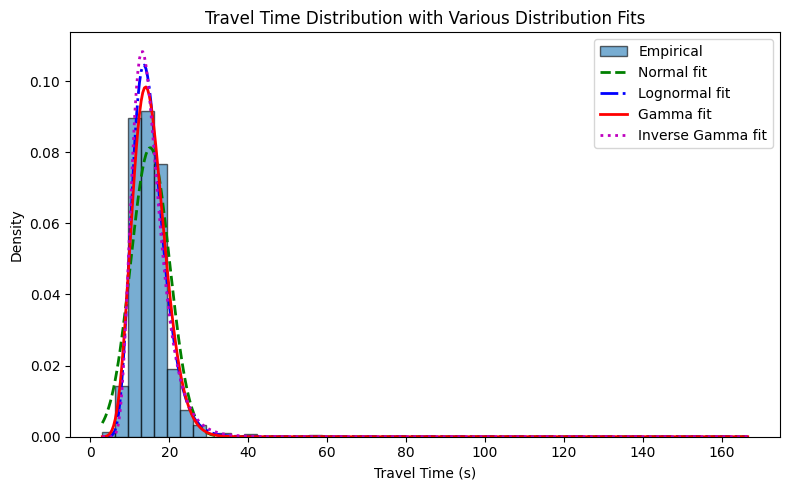

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(tt_sample, bins=50, density=True, edgecolor="black", alpha=0.6, label="Empirical")

x = np.linspace(tt_sample.min(), tt_sample.max(), 400)
ax.plot(x, norm.pdf(x, *norm_params), "g--", linewidth=2, label="Normal fit")
ax.plot(x, lognorm.pdf(x, *lognorm_params), "b-.", linewidth=2, label="Lognormal fit")
ax.plot(x, gamma.pdf(x, *gamma_params), "r-", linewidth=2, label="Gamma fit")
ax.plot(x, invgamma.pdf(x, *invgamma_params), "m:", linewidth=2, label="Inverse Gamma fit")

ax.set_xlabel("Travel Time (s)")
ax.set_ylabel("Density")
ax.set_title("Travel Time Distribution with Various Distribution Fits")
ax.legend()
plt.tight_layout()
plt.show()

Gamma distribution seems to be best for fitting the speed distributions. Initially the speed data was gamma distributed, so I expected the travel time distribution to follow an inverse gamma distribution. Howver, this doesn't seem to be the case given the test case.

#### Fitting gamma travel time distributions for all edges

In [28]:
def computeGammaParams(edges, speeds_ms_expanded):
    gamma_params_list = []
    for index, row in edges.iterrows():
        tt_distribution = row["length"] / speeds_ms_expanded  # calculate travel times for this edge with empirical speed data
        gamma_params = gamma.fit(tt_distribution, floc=0)
        gamma_params_list.append(gamma_params)
    edges['gamma_params'] = gamma_params_list
    return edges

In [29]:
# Create expanded speed samples
speeds_ms = bikeSpeeds["Speed (m/s)"].to_numpy()
counts = bikeSpeeds["Total"].to_numpy().astype(int)
speeds_ms_expanded = np.repeat(speeds_ms, counts)

# Calculate gamma parameters for all edges
edges = computeGammaParams(edges, speeds_ms_expanded)

# Modify car network

This might have to be a fully manual process, as different road types should have different distribution types, so that will need to be assigned manually

# Computation

### Create Travel Time Distributions

In [30]:
# def createTTDistribution(endNode, edgesGDF, timeBudget, interval=1, distributionType='normal', params={}):
#     # Create time range and intervals
#     maxInterval = int(timeBudget / interval)
#     x = np.linspace(0, timeBudget, maxInterval + 1)

#     # Initialize the travel time distribution DataFrame
#     TTDistributions = pd.DataFrame(
#         index=edgesGDF.index,
#         columns=np.arange(0, maxInterval + 1)
#     )

#     # Populate the TTDistribution DataFrame based on the specified distribution type
#     for index, row in edgesGDF.iterrows():
#         mu = row["travel_time"]  # mean travel time in seconds
#         sigma = 0.2 * mu  # standard deviation as 20% of mean travel time

#         # Create normal distribution for travel time
#         norm_dist = norm(loc=mu, scale=sigma)

#         # Discretize PDF values over the time range
#         pdf_values = norm_dist.pdf(x) * interval  # scale by time unit for discretization

#         # Store the PDF values in the TTDistribution column
#         TTDistributions.loc[index] = pdf_values
#     return TTDistributions

In [31]:
# Time range and interval creation
# For testing purposes, use 5 minutes and discretize into 0.1 second intervals
timeBudget = 300  # 5 minutes in seconds
interval = 1 # 1 second intervals
maxInterval = int(timeBudget / interval)
x = np.linspace(0, timeBudget, maxInterval + 1)

In [32]:
# Based on time range and interval, create travel time distributions for each edge using the gamma params
TTDistributions = pd.DataFrame(
    index=edges.index,
    columns=np.arange(0, maxInterval + 1)
)

for index, row in edges.iterrows():
    gamma_params = row["gamma_params"]  # access gamma parameters for the edge
    distribution = gamma.pdf(x, *gamma_params)  # create gamma distribution PDF values over the time range
    pdf_values = distribution * interval  # scale by time unit for discretization

    # Store the PDF values in the TTDistribution column
    TTDistributions.loc[index] = pdf_values

In [33]:
TTDistributions

0         1         2         3         4    \
u           v           key                                                
95712770    277046658   0    0.0       0.0       0.0  0.000011  0.000147   
            273245111   0    0.0       0.0  0.000005  0.000202  0.002063   
            273245096   0    0.0       0.0       0.0       0.0  0.000002   
            9159686623  0    0.0       0.0       0.0       0.0  0.000002   
95716931    559373141   0    0.0       0.0       0.0   0.00001  0.000132   
...                          ...       ...       ...       ...       ...   
10684990793 639324548   0    0.0  0.000058  0.016357  0.141644  0.295535   
            10684990777 0    0.0       0.0       0.0       0.0  0.000007   
10684990794 10684990793 0    0.0  0.001164  0.123683  0.406359  0.321681   
            272014000   0    0.0       0.0  0.000001  0.000063  0.000727   
            5674111324  0    0.0       0.0       0.0       0.0       0.0   

                                  5         6         7         8         9    \
u           v           key                                                     
95712770    277046658   0    0.000919  0.003511  0.009539  0.020201  0.035368   
            273245111   0    0.009637  0.027493  0.055806  0.088294  0.115489   
            273245096   0    0.000015  0.000079  0.000288  0.000825  0.001952   
            9159686623  0    0.000015  0.000077  0.000283  0.000811   0.00192   
95716931    559373141   0    0.000831  0.003205  0.008793  0.018807  0.033253   
...                               ...       ...       ...       ...       ...   
10684990793 639324548   0    0.282712  0.165143  0.068635  0.022235  0.005955   
            10684990777 0    0.000051  0.000247  0.000844  0.002245  0.004941   
10684990794 10684990793 0    0.116753  0.025876   0.00408  0.000501  0.000051   
            272014000   0    0.003869   0.01257  0.029057  0.052355  0.077987   
            5674111324  0    0.000003  0.000017  0.000067  0.000207  0.000532   

                             ...  291  292  293  294  295  296  297  298  299  \
u           v           key  ...                                                
95712770    277046658   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            273245111   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            273245096   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            9159686623  0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
95716931    559373141   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
10684990793 639324548   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            10684990777 0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10684990794 10684990793 0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            272014000   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            5674111324  0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                             300  
u           v           key       
95712770    277046658   0    0.0  
            273245111   0    0.0  
            273245096   0    0.0  
            9159686623  0    0.0  
95716931    559373141   0    0.0  
...                          ...  
10684990793 639324548   0    0.0  
            10684990777 0    0.0  
10684990794 10684990793 0    0.0  
            272014000   0    0.0  
            5674111324  0    0.0  

[221 rows x 301 columns]

##### Checking for distribution integrity

In [34]:
sums = TTDistributions.sum(axis=1)  # Check that the rows sum to approximately 1
edges["sums"] = sums
sums

u            v            key
95712770     277046658    0           1.0
             273245111    0           1.0
             273245096    0           1.0
             9159686623   0           1.0
95716931     559373141    0           1.0
                                   ...   
10684990793  639324548    0      0.999989
             10684990777  0           1.0
10684990794  10684990793  0      1.000153
             272014000    0           1.0
             5674111324   0           1.0
Length: 221, dtype: object

Because of some edges with really short lengths, some distributions are summing to significantly above or below 0. This section here remedies this problem by identifying flawed distributions and replacing them with a uniform distribution for simplicity. The threshold used is a distribution summing to more than 1.05 or less than 0.95.

In [35]:
errors = sums[abs(1 - sums) > 0.05]

In [36]:
sums[errors.index]

u           v           key
272013998   5598405315  0      1.237157
559262556   3942353072  0      1.415586
559262563   9147072726  0      0.460075
3942353072  559262556   0      1.415586
3942353112  3942353131  0      1.447575
3942353116  3942353115  0      1.221402
3942353119  3942353104  0      0.865075
3942353130  3942353123  0      1.206467
3942353144  3942353145  0      1.423537
3942353150  3942353142  0      1.391419
3942353153  3942353155  0      0.404498
3942417562  3942417569  0      1.445708
3942417567  3942417562  0      0.443847
3942417573  3942417576  0      1.181223
3942417576  3942417578  0      0.078236
3942417578  3942417567  0      1.333787
3942441819  3942697375  0      0.018283
3942697369  3942441826  0      0.013765
3942697372  3942697371  0      0.926202
3942697373  3942697372  0      0.940558
3942697374  3942697373  0      0.162585
5598405315  272013998   0      1.237157
9147072726  559262563   0      0.460075
dtype: object

After investigating the actual travel time distributions, it's clear that these edges are so short that the chosen interval of 1 second isn't suitable to properly capture a proper probability distribution function, leading to these errors. Checking the edge lengths and travel times shows the same thing.

In [37]:
TTDistributions.loc[errors.index]

,,,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
u,v,key,,,,,,,,,,,,,,,,,,,,,
272013998,5598405315,0,0.0,1.131469,0.105385,0.000304,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
559262556,3942353072,0,0.0,1.383487,0.032075,0.000023,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
559262563,9147072726,0,0.0,0.460067,0.000008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3942353072,559262556,0,0.0,1.383487,0.032075,0.000023,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3942353112,3942353131,0,0.0,1.432273,0.015296,0.000005,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3942353116,3942353115,0,0.0,1.107463,0.113579,0.00036,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3942353119,3942353104,0,0.0,0.86493,0.000146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3942353130,3942353123,0,0.0,1.205319,0.001148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3942353144,3942353145,0,0.0,1.416343,0.007193,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
edges.loc[errors.index, ["length","travel_time", "gamma_params", "sums"]]


,,,length,travel_time,gamma_params,sums
u,v,key,,,,
272013998,5598405315,0,5.977922,0.891484,"(13.08313740716974, 0, 0.0930314908177224)",1.237157
559262556,3942353072,0,5.293143,0.789364,"(13.083137407169842, 0, 0.08237461259049626)",1.415586
559262563,9147072726,0,3.325983,0.496002,"(13.083137407169854, 0, 0.05176066110914518)",0.460075
3942353072,559262556,0,5.293143,0.789364,"(13.083137407169842, 0, 0.08237461259049626)",1.415586
3942353112,3942353131,0,4.975457,0.741987,"(13.0831374071698, 0, 0.07743062382365384)",1.447575
3942353116,3942353115,0,6.031978,0.899546,"(13.08313740716978, 0, 0.09387273223660389)",1.221402
3942353119,3942353104,0,3.765557,0.561556,"(13.083137407169781, 0, 0.058601534529322756)",0.865075
3942353130,3942353123,0,4.191095,0.625016,"(13.08313740716987, 0, 0.06522396846917)",1.206467
3942353144,3942353145,0,4.704668,0.701605,"(13.083137407169842, 0, 0.07321646233869443)",1.423537


##### Visual error edges identification check

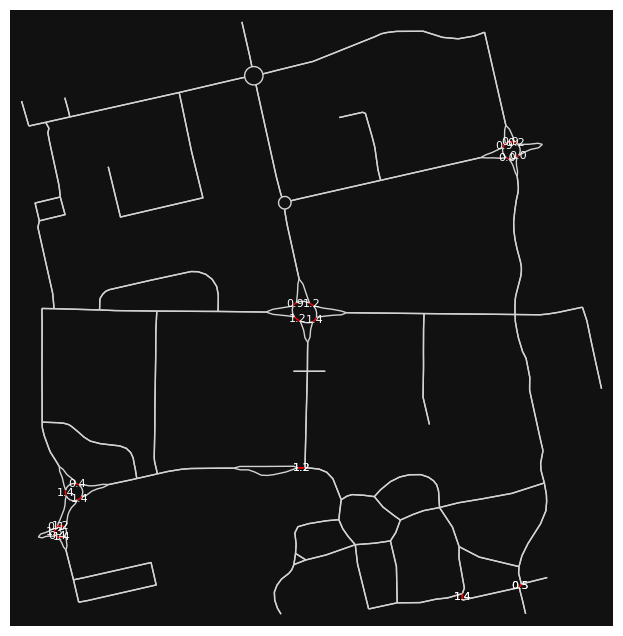

In [39]:
plotEdges = edges.copy()
plotEdges["color"] = np.where(plotEdges.index.isin(errors.index), 'red', 'lightgray')
plotGraph = ox.graph_from_gdfs(nodes, plotEdges)

# Plotting edges with errors highlighted
fig, ax = ox.plot_graph(
    plotGraph,
    node_size=0,
    edge_color=plotEdges['color'],
    # linewidths argument is a mess so I'm just skipping it
    show=False,
    close=False,
)

# Adding text for error edges
for index, data in edges.iterrows():
    if index in errors.index:
        text = f"{errors.loc[index]:.1f}"
        c = data['geometry'].centroid
        ax.annotate(text, (c.x, c.y), fontsize=8, color='white',
                   ha='center', va='center', zorder=100)

plt.show()

##### Fixing the errors

To get rid of problematic distributions and simplify the graph, I'm just setting an arbitrary 100% chance for 1 second travel time on those problematic distributions.

It shouldn't really affect the algorithm because of the low edge travel time.

In [41]:
TTDistributions.loc[errors.index] = 0
TTDistributions.loc[errors.index, 1] = 1
TTDistributions.loc[errors.index]

,,,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
u,v,key,,,,,,,,,,,,,,,,,,,,,
272013998,5598405315,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
559262556,3942353072,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
559262563,9147072726,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3942353072,559262556,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3942353112,3942353131,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3942353116,3942353115,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3942353119,3942353104,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3942353130,3942353123,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3942353144,3942353145,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Check the new pdf sums, there should be no edges with a pdf sum with more than 1.05 or less than 0.95 

In [43]:
sums = TTDistributions.sum(axis=1)  # Check that the rows sum to approximately 1
edges["sums"] = sums
sums

u            v            key
95712770     277046658    0           1.0
             273245111    0           1.0
             273245096    0           1.0
             9159686623   0           1.0
95716931     559373141    0           1.0
                                   ...   
10684990793  639324548    0      0.999989
             10684990777  0           1.0
10684990794  10684990793  0      1.000153
             272014000    0           1.0
             5674111324   0           1.0
Length: 221, dtype: object

In [44]:
sums[abs(1 - sums) > 0.05]

Series([], dtype: object)

## Algorithm

In [45]:
# Test endNode
endNode = 301036896
# endNode = 7471168568

In [46]:
TTDistributions

0         1         2         3         4    \
u           v           key                                                
95712770    277046658   0    0.0       0.0       0.0  0.000011  0.000147   
            273245111   0    0.0       0.0  0.000005  0.000202  0.002063   
            273245096   0    0.0       0.0       0.0       0.0  0.000002   
            9159686623  0    0.0       0.0       0.0       0.0  0.000002   
95716931    559373141   0    0.0       0.0       0.0   0.00001  0.000132   
...                          ...       ...       ...       ...       ...   
10684990793 639324548   0    0.0  0.000058  0.016357  0.141644  0.295535   
            10684990777 0    0.0       0.0       0.0       0.0  0.000007   
10684990794 10684990793 0    0.0  0.001164  0.123683  0.406359  0.321681   
            272014000   0    0.0       0.0  0.000001  0.000063  0.000727   
            5674111324  0    0.0       0.0       0.0       0.0       0.0   

                                  5         6         7         8         9    \
u           v           key                                                     
95712770    277046658   0    0.000919  0.003511  0.009539  0.020201  0.035368   
            273245111   0    0.009637  0.027493  0.055806  0.088294  0.115489   
            273245096   0    0.000015  0.000079  0.000288  0.000825  0.001952   
            9159686623  0    0.000015  0.000077  0.000283  0.000811   0.00192   
95716931    559373141   0    0.000831  0.003205  0.008793  0.018807  0.033253   
...                               ...       ...       ...       ...       ...   
10684990793 639324548   0    0.282712  0.165143  0.068635  0.022235  0.005955   
            10684990777 0    0.000051  0.000247  0.000844  0.002245  0.004941   
10684990794 10684990793 0    0.116753  0.025876   0.00408  0.000501  0.000051   
            272014000   0    0.003869   0.01257  0.029057  0.052355  0.077987   
            5674111324  0    0.000003  0.000017  0.000067  0.000207  0.000532   

                             ...  291  292  293  294  295  296  297  298  299  \
u           v           key  ...                                                
95712770    277046658   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            273245111   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            273245096   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            9159686623  0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
95716931    559373141   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
10684990793 639324548   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            10684990777 0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10684990794 10684990793 0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            272014000   0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
            5674111324  0    ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                             300  
u           v           key       
95712770    277046658   0    0.0  
            273245111   0    0.0  
            273245096   0    0.0  
            9159686623  0    0.0  
95716931    559373141   0    0.0  
...                          ...  
10684990793 639324548   0    0.0  
            10684990777 0    0.0  
10684990794 10684990793 0    0.0  
            272014000   0    0.0  
            5674111324  0    0.0  

[221 rows x 301 columns]

In [47]:
# Function to solve for probability and policy tables given an endNode, TTDistributions, timeBudget, and interval
# timeBudget and interval are created with TTDistributions above, do I want to pass them as part of TTDistributions?
def SOTAsolve(endNode, TTDistributions, timeBudget, interval, nodes):
    # Recalculate maxInterval based on timeBudget and interval
    maxInterval = int(timeBudget / interval)
    
    # Initilize probability and policy tables
    initializeStart = time.time() # for timing how long initialization takes
    probabilities = pd.DataFrame(
        columns= np.arange(0, maxInterval + 1),
        index=nodes.index,
    )

    probabilities.index.names = ['Start node']
    probabilities.iloc[:,:] = 0
    probabilities.loc[endNode,] = 1
    
    policy = pd.DataFrame(
        columns= np.arange(0, maxInterval + 1),
        index=nodes.index,
    )
    policy.index.names = ['Start node']
    initializeEnd = time.time() # for timing how long initialization takes
    print(f"Time to initialize policy and probabilities: {initializeEnd - initializeStart} seconds")

    # Iterate through all time budgets and solve for optimal probabilities and policies
    algorithmStart = time.time() # for timing how long the algorithm takes
    for tb in np.arange(1, maxInterval + 1):
        
        # Timing for each 100 time budgets to track performance
        if tb == 1:
            timerStart = time.time()
        if tb % 100 == 0:
            timerEnd = time.time()
            print(f"Time to complete time budget {tb}: {timerEnd - timerStart} seconds")
            timerStart = time.time()

        # Iterate through the possible start nodes
        for startNode in nodes.index:
            
            # ignore endNode
            if startNode == endNode:
                continue

            # Calculate optimal probability of reaching the end node given the start node, end node, and time budget
            # Find relevant travel time distribution values
            distributionCalc = TTDistributions.loc[startNode].iloc[:,1:tb+1]
            # Reverse travel time distribution values matrix
            distributionCalc = distributionCalc.iloc[:, ::-1]
            # Find relevant probabilities to adjacent nodes
            adjacentNodes = distributionCalc.index
            # Create probabilitiesCalc DataFrame with MultiIndex to match distributionCalc
            endNodes = adjacentNodes.get_level_values("v")
            timeRange = range(1, tb + 1)
            probabilitiesCalc = probabilities.loc[endNodes, timeRange].copy()
            probabilitiesCalc.index = adjacentNodes
            # Calculate the element-wise product of the two matrices
            result = distributionCalc.values * probabilitiesCalc.values
            # Sum the product to find probability of getting to end node based on which adjacent node is traveled to next
            row_sums = pd.Series(np.sum(result, axis=1), index=adjacentNodes)

            # Store the optimal probability, don't allow it to exceed 1
            probabilities.loc[startNode, tb] = min(row_sums.max(), 1)
            
            # Store the optimal policy
            if np.nanmax(row_sums) == 0:
                policy.loc[startNode, tb] = np.nan
            else:
                policy.loc[startNode, tb] = str(row_sums.idxmax())
    
    algorithmEnd = time.time() # for timing how long the algorithm takes
    print(f"Time to run algorithm: {algorithmEnd - algorithmStart} seconds")

    # Return the probability and policy tables
    return probabilities, policy

In [48]:
probabilities, policy = SOTAsolve(endNode, TTDistributions, timeBudget, interval, nodes=nodes)

Time to initialize policy and probabilities: 0.12494993209838867 seconds
Time to complete time budget 100: 7.383481025695801 seconds
Time to complete time budget 200: 7.559345006942749 seconds
Time to complete time budget 300: 7.860372066497803 seconds
Time to run algorithm: 22.88453984260559 seconds


In [49]:
display(probabilities, policy)

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
Start node,,,,,,,,,,,,,,,,,,,,,
95712770,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984
95716931,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.997918,0.997918,0.997918,0.997918,0.997918,0.997918,0.997918,0.997918,0.997918,0.997918
95716932,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.995218,0.995218,0.995218,0.995218,0.995218,0.995218,0.995218,0.995218,0.995218,0.995218
265024842,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999,0.99999
271831022,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999973,0.999973,0.999973,0.999973,0.999973,0.999973,0.999973,0.999973,0.999973,0.999973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156382464,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
9159686623,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984,0.999984
10684990777,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.998979,0.998979,0.998979,0.998979,0.998979,0.998979,0.998979,0.998979,0.998979,0.998979


,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
Start node,,,,,,,,,,,,,,,,,,,,,
95712770,NaN,NaN,NaN,"(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))",...,"(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))","(np.int64(273245096), np.int64(0))"
95716931,NaN,NaN,NaN,NaN,NaN,NaN,"(np.int64(9147059880), np.int64(0))","(np.int64(9147059880), np.int64(0))","(np.int64(9147059880), np.int64(0))","(np.int64(9147059880), np.int64(0))",...,"(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))","(np.int64(559373141), np.int64(0))"
95716932,NaN,NaN,NaN,NaN,NaN,"(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))",...,"(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))","(np.int64(3942697372), np.int64(0))"
265024842,NaN,NaN,NaN,NaN,"(np.int64(3942353116), np.int64(0))","(np.int64(3942353116), np.int64(0))","(np.int64(3942353116), np.int64(0))","(np.int64(3942353116), np.int64(0))","(np.int64(3942353116), np.int64(0))","(np.int64(3942353116), np.int64(0))",...,"(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))","(np.int64(480680078), np.int64(0))"
271831022,NaN,NaN,NaN,NaN,NaN,NaN,"(np.int64(9156382463), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))","(np.int64(9147059860), np.int64(0))",...,"(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9156382464,NaN,NaN,NaN,NaN,NaN,"(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))",...,"(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))","(np.int64(9156382463), np.int64(0))"
9159686623,NaN,NaN,NaN,"(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int64(0))","(np.int64(95712770), np.int6

# Debugging

In [50]:
probabilities[abs(probabilities[300] - 1) > 0.1]

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
Start node,,,,,,,,,,,,,,,,,,,,,
272026503,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.422082,0.422083,0.422083,0.422083,0.422083,0.422083,0.422084,0.422084,0.422084,0.422084
559262556,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
559262562,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
559262563,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
559373388,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.422091,0.422091,0.422092,0.422092,0.422092,0.422092,0.422092,0.422092,0.422093,0.422093
559373389,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.422096,0.422097,0.422097,0.422097,0.422097,0.422097,0.422097,0.422098,0.422098,0.422098
3942353112,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3942353144,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3942353153,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


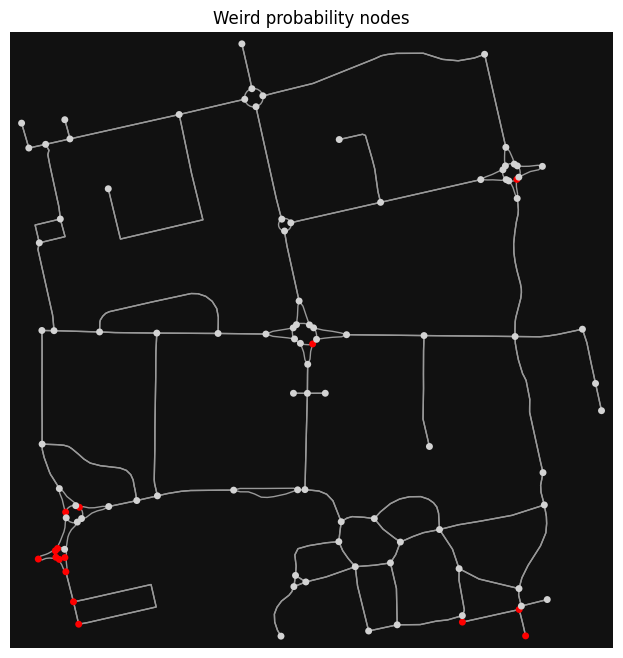

In [51]:
probabilityErrors = probabilities[abs(probabilities[300] - 1) > 0.1].loc[:,300]
nodes["color"] = np.where(nodes.index.isin(probabilityErrors.index), 'red', 'lightgray')

fig, ax = ox.plot_graph(testGraph, node_color=nodes["color"], node_size=25, edge_linewidth=1, show=False, close=False)
ax.set_title(f'Weird probability nodes')
plt.show()